In [1]:
from urllib.request import urlopen
from io import BytesIO
from PIL import Image
from imagehash import phash
from pyspark.sql import functions as F
from pyspark.sql import types as T
import numpy as np

In [2]:
df = sqlContext.read.parquet("/guoda/data/idigbio-media-20170709T013207-100k.parquet")

In [10]:
df2 = df.sample(False,0.005,45) # to select small dataframe for faster execution 
df2.count()

513

In [3]:
def imagebytes(v):
    try:
        b = BytesIO()
        sqr = (Image.open(BytesIO(urlopen("http://api.idigbio.org/v2/media?size=thumbnail&filereference=" + v).read()))).resize((256,256),Image.LANCZOS)
        sqr.save(b,format="jpeg")
        b.seek(0)
        return b.read()
    except:
        return np.nan

In [6]:
imgb_udf = F.udf(imagebytes, T.BinaryType())
newdf = df2.select("accessuri",imgb_udf("accessuri"))

In [7]:
newdf.printSchema()
newdf.groupby("imagebytes(accessuri)").count().sort(F.col("count").desc()).show()

root
 |-- accessuri: string (nullable = true)
 |-- imagebytes(accessuri): binary (nullable = true)

+---------------------+-----+
|imagebytes(accessuri)|count|
+---------------------+-----+
|                 null|  134|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
| [FF D8 FF E0 00 1...|    1|
+---------------------+-----+
only showing top 20 rows



In [8]:
newdf.show()

+--------------------+---------------------+
|           accessuri|imagebytes(accessuri)|
+--------------------+---------------------+
|http://mediaphoto...| [FF D8 FF E0 00 1...|
|http://mediaphoto...| [FF D8 FF E0 00 1...|
|http://mediaphoto...| [FF D8 FF E0 00 1...|
|http://mediaphoto...| [FF D8 FF E0 00 1...|
|http://bovary.ipl...|                 null|
|http://bovary.ipl...|                 null|
|http://bovary.ipl...|                 null|
|http://arctos.dat...| [FF D8 FF E0 00 1...|
|http://mediaphoto...| [FF D8 FF E0 00 1...|
|http://mediaphoto...| [FF D8 FF E0 00 1...|
|http://mediaphoto...| [FF D8 FF E0 00 1...|
|http://cdm15705.c...| [FF D8 FF E0 00 1...|
|http://mediaphoto...| [FF D8 FF E0 00 1...|
|http://mediaphoto...| [FF D8 FF E0 00 1...|
|http://mediaphoto...| [FF D8 FF E0 00 1...|
|http://mediaphoto...| [FF D8 FF E0 00 1...|
|http://mediaphoto...| [FF D8 FF E0 00 1...|
|http://mediaphoto...| [FF D8 FF E0 00 1...|
|http://mediaphoto...| [FF D8 FF E0 00 1...|
|http://me

In [12]:
newdf.first()[1]

bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xc

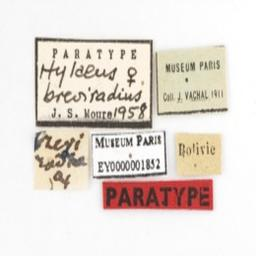

In [13]:
# accessing image back from bytestream
Image.open(BytesIO(newdf.first()[1]))